# Magic Methods!

[Slides](https://docs.google.com/presentation/d/13rnvQ7w2YT3WQKgDDAEd7Unlf67WcgzYVN3uGt-vJP8/edit?usp=sharing)

1. You can't not use magic methods
2. String magic
3. Math-y magic (Infix Methods)
4. Ordering magic
5. Container magic
6. Proprietary magic (IPython Notebook)

## ✨ 1. There's a little magic in everything ✨

In [1]:
class MyObj:
    pass
    
obj = MyObj()

That called `object.__init__`

In [2]:
obj

That called `obj.__repr__`

In [3]:
print(obj)

That called `obj.__str__`

<br><br><br>

---

<br><br><br>

<br><br><br>

## 2. Stringy Magic

Implementing [`__repr__`](https://docs.python.org/3/reference/datamodel.html#object.__repr__) and [`__str__`](https://docs.python.org/3/reference/datamodel.html#object.__str__) can often be useful when debugging or manipulating objects interactively (like via Notebooks or REPLs)

In [4]:
class Stringy:
    def __init__(self, name):
        self.name = name

    def __repr__(self) -> str:
        """
        ...If at all possible, this should look like a valid Python expression 
        that could be used to recreate an object with the same value. If this 
        is not possible, a string of the form <...some useful description...> 
        should be returned. 
        """
        return f"{self.__class__.__name__}('{self.name}')"
    
    def __str__(self) -> str:
        """        
        This method differs from `__repr__()` in that there is no expectation 
        that `__str__()` returns a valid Python expression: a more convenient 
        or concise representation can be used.
        """
        return f"Name: {self.name}"

In [5]:
a = Stringy('apple')
a

Stringy('apple')

In [6]:
repr(a)

"Stringy('apple')"

In [12]:
# "round-trippable"
eval(repr(a))

Stringy('apple')

In [13]:
print(a)

Name: apple


---

Why not something like:

In [8]:
class StringyToo:
    def __init__(self, name):
        self.name = name
        
    def to_string(self):
        return f"Name: {self.name}"

In [9]:
b = StringyToo('cheese')
b

In [10]:
b.to_string()

'Name: cheese'

In [11]:
print(b)

* Non-standard. Python already has a method for it
* If you want to take formatting arguments, implement `__format__`

<br><br><br>

---

<br><br><br>

<br><br><br>

## 3. Container Magic

`__(get|set|del)item__`, `__contains__`, `__len__`, `__iter__`, `__next__`, `__reversed__`...

In [66]:
from contextlib import suppress

# DIY https://docs.python.org/3/library/collections.html#collections.ChainMap

class FallbackDict:
    """Look through a series of dicts in order"""
    
    def __init__(self, *dicts):
        self.dicts = dicts

    def lookup(self, key):
        for d in self.dicts:
            with suppress(KeyError):  
                return d[key]
        raise KeyError(key)

In [44]:
dicts = [
    {"name": "pyconie", "misc": "woot"},
    {"misc": "etc"},
    {"name": "unknown", "greeting": "hello"},
]
fbd = FallbackDict(*dicts)

fbd.lookup("name")

'pyconie'

In [41]:
dicts[2]["greeting"]

'hello'

In [42]:
f'{fbd["greeting"]}, {fbd["name"]}!'

TypeError: 'FallbackDict' object is not subscriptable

<br><br>

It's kinda like a dictionary, we can index into it and get items, but not much else.

In [38]:
len(fbd)  # probably should be 3?

TypeError: object of type 'FallbackDict' has no len()

In [25]:
[k for k in fbd.values()]  # should be 'woot', 'hello', 'chipy'

AttributeError: 'FallbackDict' object has no attribute 'values'

In [26]:
'name' in fbd  # is a key in it?

TypeError: argument of type 'FallbackDict' is not iterable

In [27]:
# would be nice to convert to a normal dict if we wanted to JSON serialize it
dict(fbd)

TypeError: 'FallbackDict' object is not iterable

### [Abstract Base Classes for Containers](https://docs.python.org/3/library/collections.abc.html) (`collections.abc`)

Amplify your magics! If you implement the abstract methods required by the type, it can provide additional mixin methods for free. Lets make our `FallbackDict` more `dict`-like by using the `Mapping` ABC (read-only dict)

In [59]:
import collections.abc


# the M is for Mmmproved Mapping
class FallbackDictM(FallbackDict, collections.abc.Mapping):
    # __init__, __getitem__ from FallbackDict
    
    def _all_keys(self):
        all_keys = set()
        for d in self.dicts:
            all_keys |= set(d)
        return all_keys
    
    def __len__(self):
        return len(self._all_keys())

    def __iter__(self):
        for key in self._all_keys():
            yield key

In [60]:
fbdm = FallbackDictM(*dicts)

In [61]:
print(len(fbdm))  # directly hitting __len__
for key in fbdm:  # hits __iter__
    print(f"{key:>10s}: {fbdm[key]}")

3
      misc: woot
      name: pyconie
  greeting: hello


In [62]:
list(fbdm.values())  # values method for free

['woot', 'pyconie', 'hello']

In [63]:
'name' in fbdm  # __contains__ for free

True

In [64]:
flattened = dict(fbdm)
flattened

{'misc': 'woot', 'name': 'pyconie', 'greeting': 'hello'}

In [65]:
flattened == fbdm  # __eq__ for free

True

<br><br><br>

---

<br><br><br>

In [67]:
from helpers import verbose_method

## 4. Math-y Magic

Implementing the mathematical magic methods can let you use any of the infix operators to manipulate your objects as makes sense.

    x + y     __add__             x & y   __and__
    x - y     __sub__             x | y   __or__      
    x * y     __mul__             x ^ y   __xor__
    x / y     __truediv__         x << y  __lshift__
    x // y    __floordiv__        x >> y  __rshift__
    x ** y    __pow__           
    x % y     __mod__           (unary prefix operators)  
    x @ y     __matmul__          -x      __neg__
                                  +x      __pos__

In [68]:
(3).__add__(5)

8

The operators can be (ab)used in other contexts. Don't go crazy with it: keep it sensible. 

Let's DIY `pathlib.Path`:

In [69]:
class PathyBase:
    def __init__(self, path):
        self.path = path

    def __repr__(self):
        return f"{self.__class__.__name__}({self.path!r})"


class PathA(PathyBase):
    @verbose_method
    def __truediv__(self, other) -> str:
        return self.__class__(self.path + '/' + other.path)

In [70]:
PathA('aaa') / PathA('bbb')

call: PathA('aaa').__truediv__(PathA('bbb')) => PathA('aaa/bbb')


PathA('aaa/bbb')

In [71]:
# identical to above
PathA('aaa').__truediv__(PathA('bbb'))

call: PathA('aaa').__truediv__(PathA('bbb')) => PathA('aaa/bbb')


PathA('aaa/bbb')

---

`PathA` shortcoming: only works when all parts are `Path` objects, can't incorporate a string

In [72]:
class PathB(PathyBase):
    @verbose_method
    def __truediv__(self, other):
        if isinstance(other, self.__class__):
            other_value = other.path
        else:
            other_value = other

        return self.__class__(self.path + '/' + other_value)

In [73]:
PathB('ccc') / 'ddd'

call: PathB('ccc').__truediv__('ddd') => PathB('ccc/ddd')


PathB('ccc/ddd')

In [74]:
PathB('ccc') / 'ddd' / 'eee'

call: PathB('ccc').__truediv__('ddd') => PathB('ccc/ddd')
call: PathB('ccc/ddd').__truediv__('eee') => PathB('ccc/ddd/eee')


PathB('ccc/ddd/eee')

---

`PathB` shortcomings:

In [75]:
'ccc' / PathB('ddd')

TypeError: unsupported operand type(s) for /: 'str' and 'PathB'

In [76]:
result = 'usr' / PathB('bin') / 'python'

TypeError: unsupported operand type(s) for /: 'str' and 'PathB'

In [77]:
# equivalent
_intermediate = 'usr' / PathB('bin')
result = _intermediate / 'python'

TypeError: unsupported operand type(s) for /: 'str' and 'PathB'

---

To support those operand type(s), we use the [*reflected* methods](https://docs.python.org/3/reference/datamodel.html?#object.__radd__), `__r*__`. When the "forward" direction fails, Python will attempt to call it the other way, so `'usr' + PathB('lib')` is effectively something like:

```python
try:
    'usr'.__truediv__(PathB('lib'))   # the str type doesn't know what a Path is
except TypeError:
    PathB('lib').__rtruediv__('usr')  # but we have the option to do something!
```

Numeric Demo:

In [78]:
(2).__rsub__(100)

98

In [79]:
(2).__rtruediv__(100)

50.0

---

In [80]:
class PathC(PathB):
    # __truediv__ from PathB

    @verbose_method
    def __rtruediv__(self, other) -> str:
        """
        Note that the order of arguments are reversed on the call; 
        so `self` will be the object *after* the infix operator, and 
        `other` the one before.
        
        We're also assuming that other is an integer, Path / Path
        operations will just use __truediv__ from the first one.
        """
        return self.__class__(other + '/' + self.path)

In [81]:
'bin' / PathC('bash')

call: PathC('bash').__rtruediv__('bin') => PathC('bin/bash')


PathC('bin/bash')

In [82]:
PathC('home') / PathC('nick')

call: PathC('home').__truediv__(PathC('nick')) => PathC('home/nick')


PathC('home/nick')

In [83]:
PathC('home') / 'nick' / PathC('Code')

call: PathC('home').__truediv__('nick') => PathC('home/nick')
call: PathC('home/nick').__truediv__(PathC('Code')) => PathC('home/nick/Code')


PathC('home/nick/Code')

In [85]:
PathC('home') / 'nick' / 'Code' / 'talks/pyconie'

call: PathC('home').__truediv__('nick') => PathC('home/nick')
call: PathC('home/nick').__truediv__('Code') => PathC('home/nick/Code')
call: PathC('home/nick/Code').__truediv__('talks/pyconie') => PathC('home/nick/Code/talks/pyconie')


PathC('home/nick/Code/talks/pyconie')

### More Abstract Mixins

The built-in `open()` accepts objects that are [`os.PathLike`](https://docs.python.org/3/library/os.html#os.PathLike) (new in 3.6). `PathLike` is an **abstract base class** that objects can define to specify how they are path-like.

In [88]:
import os

class PathD(PathC, os.PathLike):
    @verbose_method
    def __fspath__(self):
        return os.path.expanduser(self.path)

In [93]:
print('building path')
ignore = PathD('~') / '.gitignore_global'

print('opening it!')
with open(ignore) as f:
    print('\nFile Contents:\n==============')
    for line in f:
        print(line, end="")

building path
call: PathD('~').__truediv__('.gitignore_global') => PathD('~/.gitignore_global')
opening it!
call: PathD('~/.gitignore_global').__fspath__() => '/home/nick/.gitignore_global'

File Contents:
*.py[cod]
__pycache__/
_build



We've created a hacky version of [`pathlib`](https://docs.python.org/3/library/pathlib.html), a standard library package.  Use that one instead, but be inspired to create something else.

```
















```

## 5. Ordering Magic

The Methods: `__eq__`, `__ne__`, `__lt__`, `__le__`, `__gt__`, `__ge__`

In [94]:
versions = [
    '0.9.4',
    '0.95.3',
    '0.10.5',
    '0.9.34',
    '0.10.42',
    '1.4.2',
]

In [95]:
sorted(versions)

['0.10.42', '0.10.5', '0.9.34', '0.9.4', '0.95.3', '1.4.2']

How can we sort these? We could pass a `key` argument into `sorted()`:

In [96]:
sorted(versions, key=lambda i: [int(p) for p in i.split('.')])

['0.9.4', '0.9.34', '0.10.5', '0.10.42', '0.95.3', '1.4.2']

In [97]:
class Version:
    def __init__(self, version):
        self.version = version
        self.major, self.minor, self.patch = (int(x) for x in version.split('.'))
    
    def __repr__(self):
        return f'{self.__class__.__name__}({self.version!r})'

    @verbose_method
    def __lt__(self, other):
        return (
            (self.major, self.minor, self.patch) 
            < (other.major, other.minor, other.patch)
        )

In [98]:
Version('0.32.52') < Version('0.93.2')

call: Version('0.32.52').__lt__(Version('0.93.2')) => True


True

In [295]:
Version('10.0.0') < Version('9.99.999')

call: Version('10.0.0').__lt__(Version('9.99.999')) => False


False

In [296]:
Version('10.0.0') <= Version('9.99.999')

TypeError: '<=' not supported between instances of 'Version' and 'Version'

---

In [297]:
import functools

@functools.total_ordering
class Version2(Version):
    # __lt__ from Version
    
    @verbose_method
    def __eq__(self, other):
        return (
            (self.major, self.minor, self.patch) 
            == (other.major, other.minor, other.patch)
        )
    
    # __gt__, __ge__, __le__ from total_ordering

In [298]:
Version2("1.23.42") > Version2("1.5.99")

call: Version2('1.23.42').__lt__(Version2('1.5.99')) => False
call: Version2('1.23.42').__eq__(Version2('1.5.99')) => False


True

---

In [299]:
version_objs = [Version(v) for v in versions]
version_objs

[Version('0.9.4'),
 Version('0.95.3'),
 Version('0.10.5'),
 Version('0.9.34'),
 Version('0.10.42'),
 Version('1.4.2')]

In [300]:
sorted(version_objs)

call: Version('0.95.3').__lt__(Version('0.9.4')) => False
call: Version('0.10.5').__lt__(Version('0.95.3')) => True
call: Version('0.10.5').__lt__(Version('0.95.3')) => True
call: Version('0.10.5').__lt__(Version('0.9.4')) => False
call: Version('0.9.34').__lt__(Version('0.10.5')) => True
call: Version('0.9.34').__lt__(Version('0.9.4')) => False
call: Version('0.10.42').__lt__(Version('0.10.5')) => False
call: Version('0.10.42').__lt__(Version('0.95.3')) => True
call: Version('1.4.2').__lt__(Version('0.10.5')) => False
call: Version('1.4.2').__lt__(Version('0.95.3')) => False


[Version('0.9.4'),
 Version('0.9.34'),
 Version('0.10.5'),
 Version('0.10.42'),
 Version('0.95.3'),
 Version('1.4.2')]

In [301]:
max(version_objs)

call: Version('0.9.4').__lt__(Version('0.95.3')) => True
call: Version('0.95.3').__lt__(Version('0.10.5')) => False
call: Version('0.95.3').__lt__(Version('0.9.34')) => False
call: Version('0.95.3').__lt__(Version('0.10.42')) => False
call: Version('0.95.3').__lt__(Version('1.4.2')) => True


Version('1.4.2')

In [302]:
min(version_objs)

call: Version('0.95.3').__lt__(Version('0.9.4')) => False
call: Version('0.10.5').__lt__(Version('0.9.4')) => False
call: Version('0.9.34').__lt__(Version('0.9.4')) => False
call: Version('0.10.42').__lt__(Version('0.9.4')) => False
call: Version('1.4.2').__lt__(Version('0.9.4')) => False


Version('0.9.4')

Also, not everything can take a `key` argument:

In [303]:
import heapq

version_heap = version_objs[:]
heapq.heapify(version_heap)

call: Version('0.10.5').__lt__(Version('1.4.2')) => True
call: Version('0.9.34').__lt__(Version('0.10.42')) => True
call: Version('0.95.3').__lt__(Version('0.9.34')) => False
call: Version('0.9.34').__lt__(Version('0.10.5')) => True
call: Version('0.95.3').__lt__(Version('0.10.42')) => False
call: Version('0.9.4').__lt__(Version('0.10.42')) => True
call: Version('0.9.4').__lt__(Version('0.9.34')) => True


In [304]:
while version_heap:
    print(heapq.heappop(version_heap))

call: Version('0.9.34').__lt__(Version('0.10.5')) => True
call: Version('0.95.3').__lt__(Version('0.10.42')) => False
call: Version('1.4.2').__lt__(Version('0.10.42')) => False
Version('0.9.4')
call: Version('0.10.42').__lt__(Version('0.10.5')) => False
call: Version('1.4.2').__lt__(Version('0.10.5')) => False
Version('0.9.34')
call: Version('0.10.42').__lt__(Version('1.4.2')) => True
call: Version('0.95.3').__lt__(Version('0.10.42')) => False
Version('0.10.5')
call: Version('1.4.2').__lt__(Version('0.95.3')) => False
Version('0.10.42')
Version('0.95.3')
Version('1.4.2')


<br><br>

---

<br><br>

<br><br>

<br><br>

## 6. Proprietary Magic

https://ipython.readthedocs.io/en/stable/config/integrating.html#rich-display

IPython notebook can display richer representations of objects. To use this, you can define any of a number of `_repr_*_()` methods. Note that these are surrounded by single, not double underscores.

The notebook can display `svg`, `png`, `jpeg`, `html`, `javascript`, `markdown` and `latex`. If the methods don’t exist, or return `None`, it falls back to a standard `repr()`.

In [149]:
from helpers import get_xkcd_hotlink
get_xkcd_hotlink(1001)

'https://imgs.xkcd.com/comics/aaaaaa.png'

In [150]:
import functools
import requests

class XKCDComic:
    def __init__(self, url):
        self.url = url
        self.png = None
        
    def load(self):
        response = requests.get(self.url)
        response.raise_for_status()
        self.png = response.content
        
    def _repr_png_(self):
        if self.png is None:
            self.load()
        return self.png

class XKCDViewer:
    @functools.lru_cache()
    def __getitem__(self, key):
        url = get_xkcd_hotlink(key)
        if url is None:
            raise KeyError("couldn't find XKCD comic with that number")
        return XKCDComic(url)

xkcd = XKCDViewer()

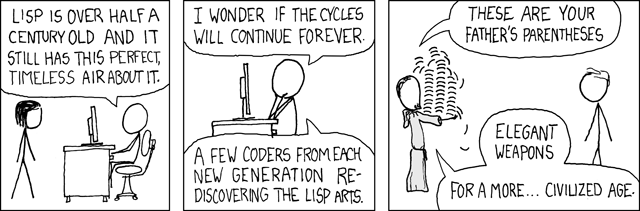

In [151]:
ANTIGRAVITY = 353
BOBBY_TABLES = 327
PYTHON_ENV = 1987
SANDWICH = 149
PARENS = 297

xkcd[PARENS]

<br><br>

<br><br><br><br><hr><br><br><br><br>

<br><br>

## Bonus: Context Managers

In [152]:
class Suppressor:
    """
    https://docs.python.org/3/reference/datamodel.html#with-statement-context-managers
    """
    def __init__(self, exc_ignore):
        self.exc_ignore = exc_ignore

    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        """
        ... If an exception is supplied, and the method wishes to suppress the 
        exception, it should return a true value. ...
        """
        return (
            exc_type is not None 
            and issubclass(exc_type, self.exc_ignore)
        )

In [153]:
with Suppressor(IndexError):
    print('abcde'[:3])  # works normally

with Suppressor(IndexError):
    print('abcde'[1000])  # raises an error, but it gets suppressed
    
print('mmmkay')

abc
mmmkay


In [154]:
with Suppressor(RuntimeError):
    'abcde'[1000]  # raises the wrong error

IndexError: string index out of range

We basically re-implemented [`contextlib.suppress`](https://docs.python.org/3/library/contextlib.html#contextlib.suppress) [(source)](https://github.com/python/cpython/blob/cca4eec3c0/Lib/contextlib.py#L342) from the standard lib.

In [127]:
import traceback

class expect_exception:
    """
    Expect an exception and trap it. Helps run all of a notebook
    that may have intentional errors for pedagogical reasons
    """
    def __init__(self, *exc_types):
        self.exc_types = exc_types
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, tb):
        if exc_type is None:
            raise RuntimeError('expected exception did not occur!')
        if issubclass(exc_type, self.exc_types):
            traceback.print_exception(exc_type, exc_value, tb)
            return True

In [131]:
with expect_exception(AttributeError):
    PathA('a') / 'b'

print("I'm not dead yet")

call: PathA('a').__truediv__('b') =X 'AttributeError("\'str\' object has no attribute \'path\'")'
I'm not dead yet


Traceback (most recent call last):
  File "<ipython-input-131-607bf4cd8fd0>", line 2, in <module>
    PathA('a') / 'b'
  File "/home/nick/Code/talks-magicmethods/helpers.py", line 11, in _method
    result = method(self, *args)
  File "<ipython-input-69-78ced35de376>", line 12, in __truediv__
    return self.__class__(self.path + '/' + other.path)
AttributeError: 'str' object has no attribute 'path'


<br><br>

## Penalty Time: Pad time with audience questions

* Punt: Name your favorite bit of syntax! (maybe magic methods are involved)
* Live Coding/Comedy: Have me implement the magic method of your choice!

In [130]:
class MyObj:
    def __x__(self, xyz):
        ...

<br><br><br><br><hr><br><br><br><br>

<br><br>

## Wow, that went fast, still need more content?

In [124]:
class IPv4:
    def __init__(self, address):
        self.address = address
        self.bits = bytes(int(p) for p in address.split("."))
        
    def __repr__(self):
        return f"{self.__class__.__name__}({self.address!r})"
        
    def __truediv__(self, bits):
        return IPv4Range(self.address, bits)
    
class IPv4Range:
    def __init__(self, address, mask_bits):
        bits = bytes(int(p) for p in address.split("."))
        num = int.from_bytes(bits, "big")
        num = num & ~((1 << (32 - mask_bits)) - 1)
        self.bits = num.to_bytes(4, "big")
        self.address = ".".join(str(n) for n in self.bits)
        
    def __repr__(self):
        return f"{self.__class__.__name__}({self.address!r})"
    
addr = IPv4("10.23.42.2")
addr_range = addr / 20
print(addr)
print(addr_range)

IPv4('10.23.42.2')
IPv4Range('10.23.32.0')


CSS hacks for more efficient space use 

In [31]:
%%html
<style>
div.prompt {
    min-width: 11ex;
}
</style>